In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, v_measure_score
import random
import pandas as pd
import seaborn as sns

# Set OpenMP environment variable to avoid the memory leak warning
os.environ["OMP_NUM_THREADS"] = "1"

In [3]:
# File paths for dimension-reduced features
pge_feature_path = 'colon_nct_feature/pge_dim_reduced_feature.h5'
vgg16_feature_path = 'colon_nct_feature/pge_dim_reduced_feature.h5'

# Load the h5 files
pge_feature_file = h5py.File(pge_feature_path, mode='r')
vgg16_feature_file = h5py.File(vgg16_feature_path, mode='r')


In [4]:
# UMAP features 
pge_umap_features = pge_feature_file['umap_feature'][...]
vgg16_umap_features = vgg16_feature_file['umap_feature'][...]

# PCA features 
pge_pca_features = pge_feature_file['pca_feature'][...]
vgg16_pca_features = vgg16_feature_file['pca_feature'][...]

In [5]:
#Combining UMAP and PCA features
pge_all_features=pge_umap_features+pge_pca_features
vgg16_all_features=vgg16_umap_features+vgg16_pca_features

# Tissue type - ground-truth labels
pge_labels = [x.decode('utf-8').split('/')[2] for x in np.squeeze(pge_feature_file['file_name'])]
vgg16_labels = [x.decode('utf-8').split('/')[2] for x in np.squeeze(vgg16_feature_file['file_name'])]

In [6]:
# Randomly sample indices
random.seed(0)
pge_indices = random.sample(range(len(pge_all_features)), 200)
vgg16_indices = random.sample(range(len(vgg16_all_features)), 200)

# Select test data
test_data_pge = pge_all_features[pge_indices]
test_labels_pge = np.array(pge_labels)[pge_indices]
test_data_vgg16 = vgg16_all_features[vgg16_indices]
test_labels_vgg16 = np.array(vgg16_labels)[vgg16_indices]

In [7]:
# K-means clustering with n_init set to suppress the future warning
silhouette_scores_pge, v_measure_scores_pge, silhouette_scores_vgg16, v_measure_scores_vgg16 = [], [], [], []
num_clusters_list = range(2, 17)  # Changed the range to 2 to 16

# Initialize variables to store best cluster size and corresponding scores
best_cluster_pge = {"silhouette": {"size": 0, "score": -1}, "v_measure": {"size": 0, "score": -1}}
best_cluster_vgg16 = {"silhouette": {"size": 0, "score": -1}, "v_measure": {"size": 0, "score": -1}}

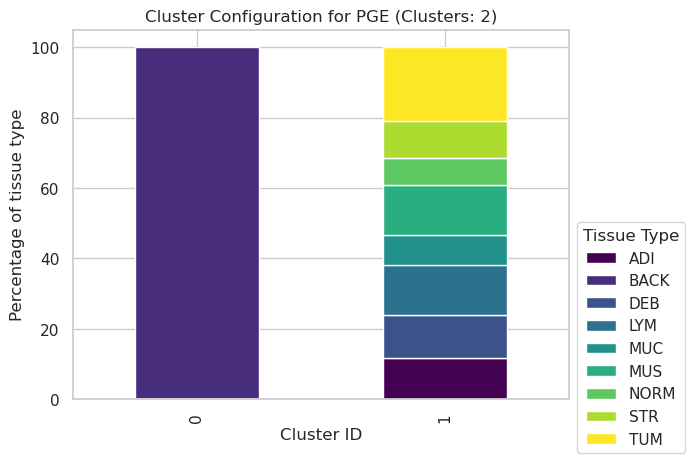

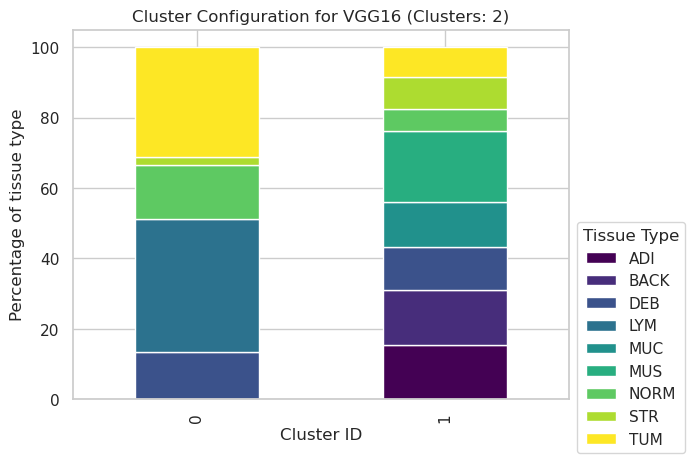

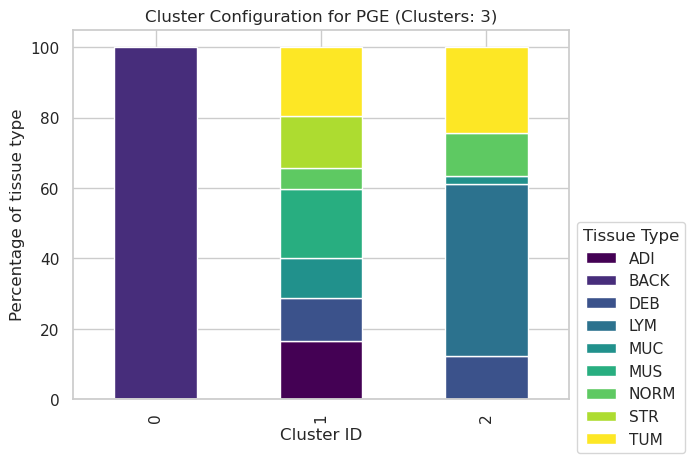

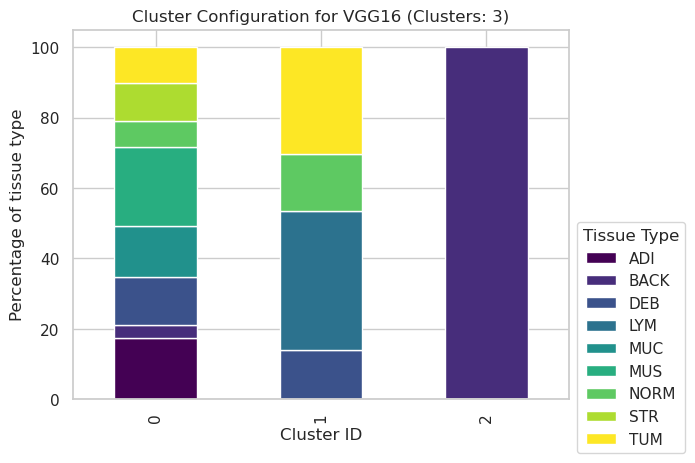

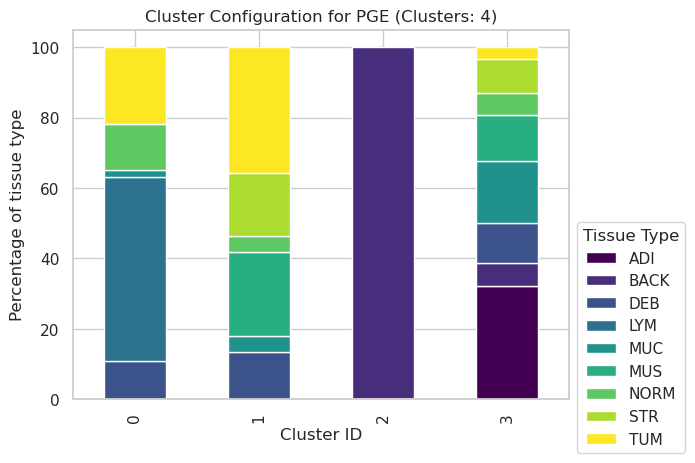

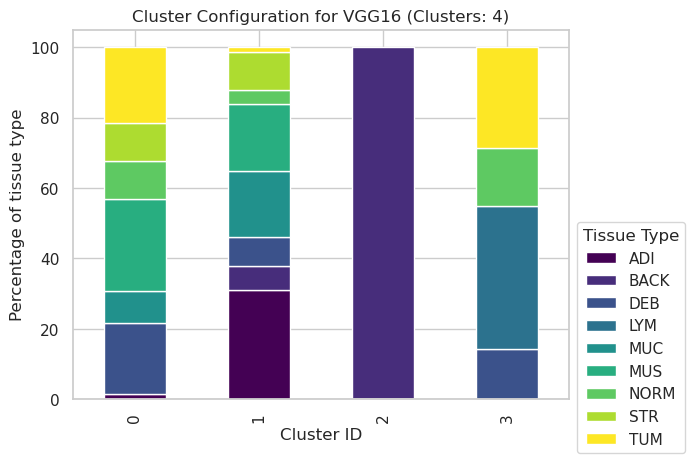

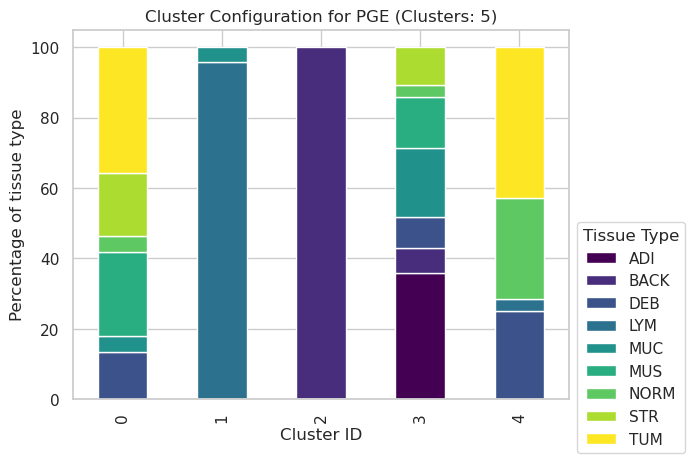

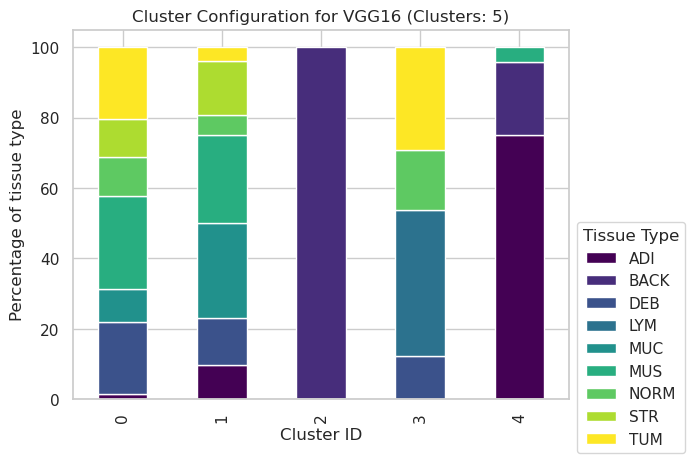

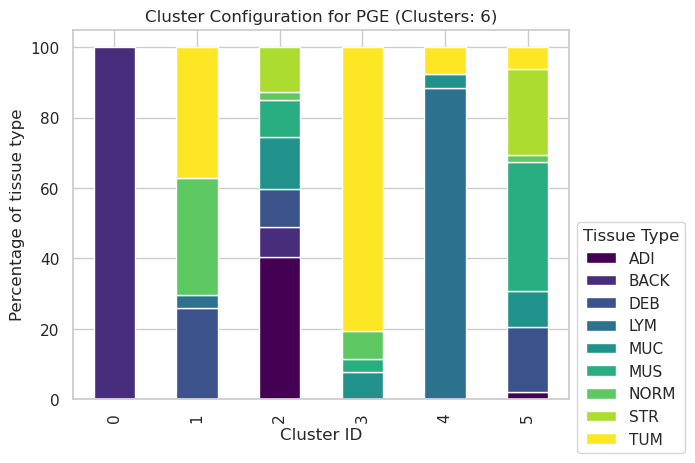

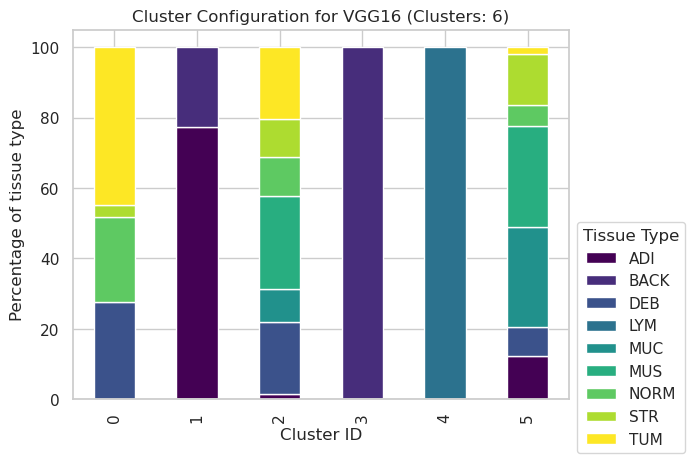

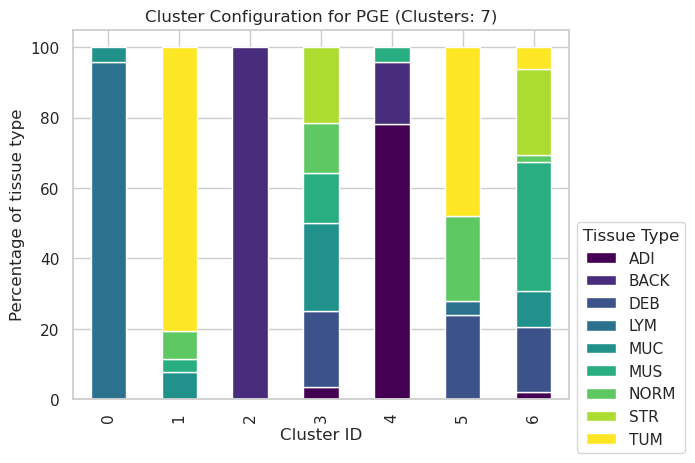

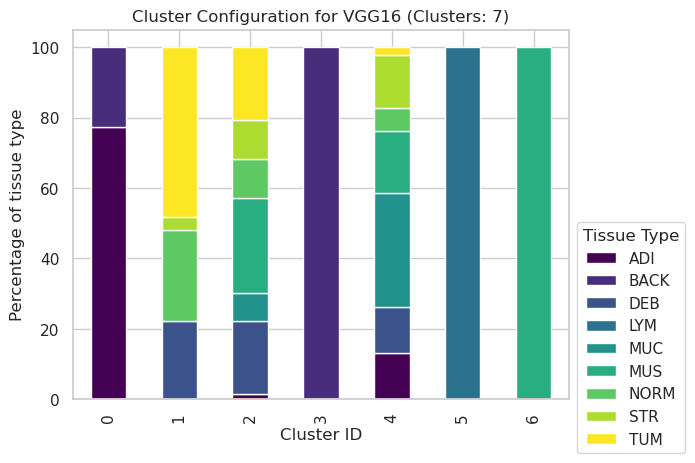

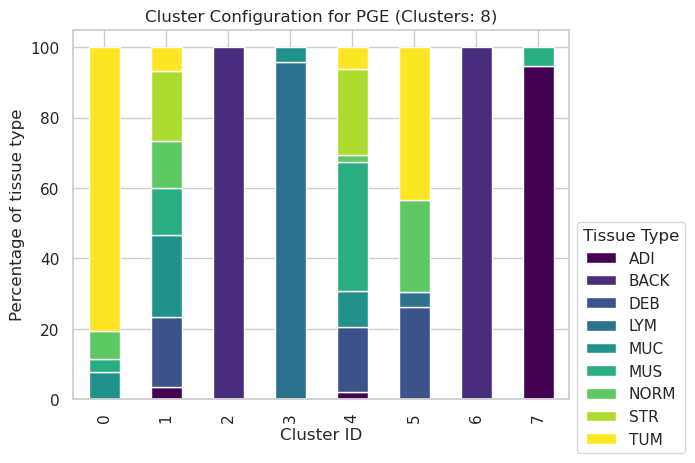

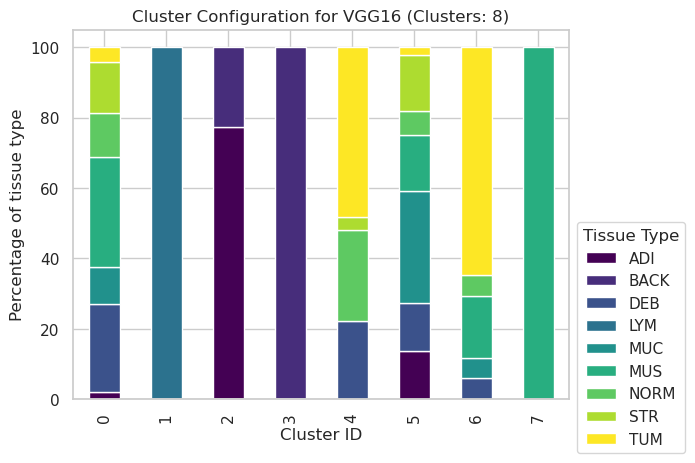

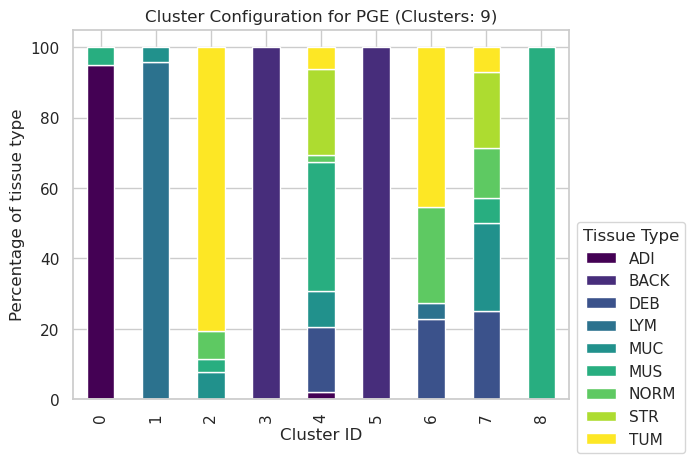

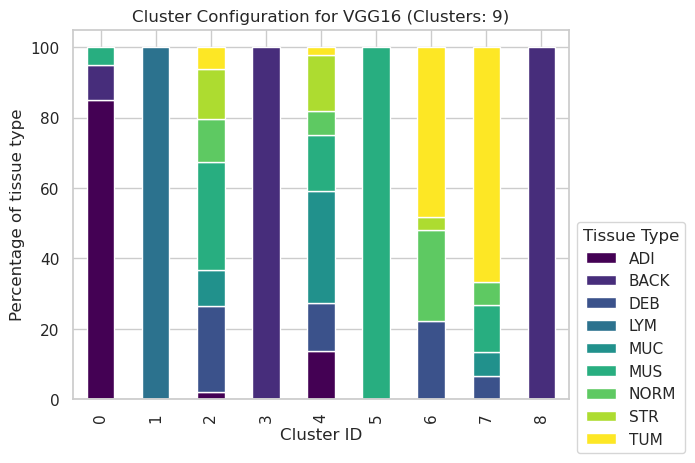

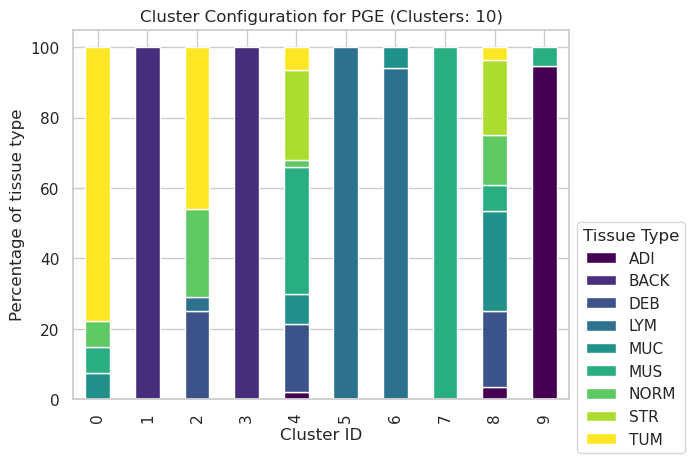

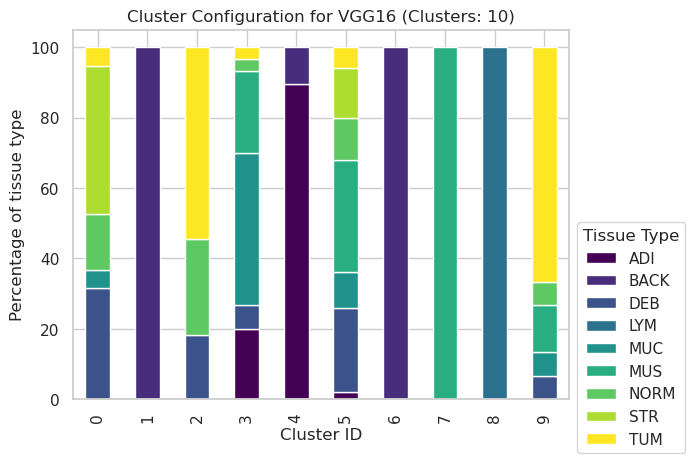

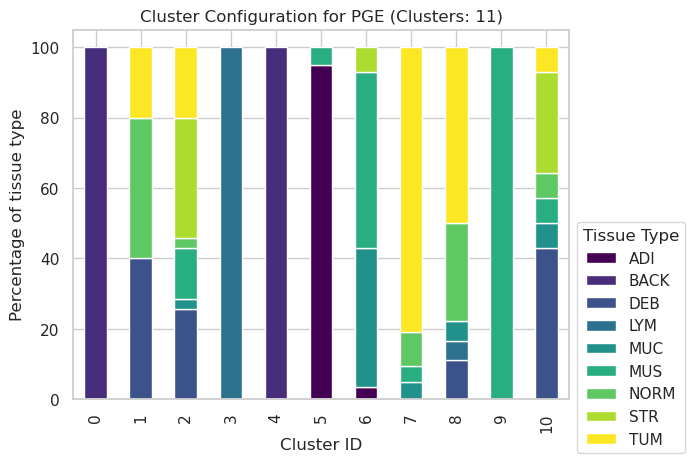

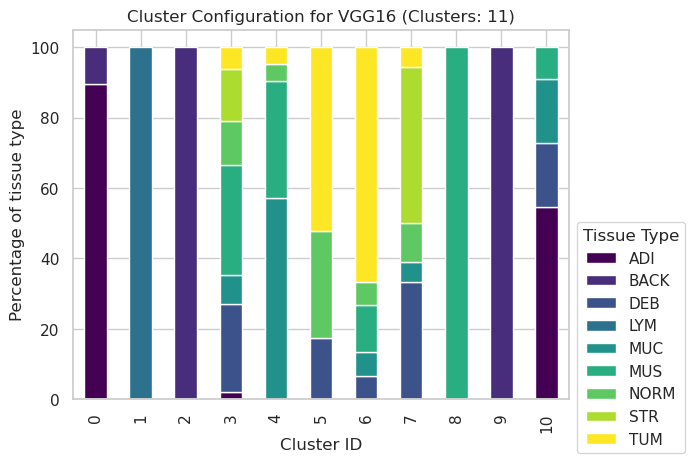

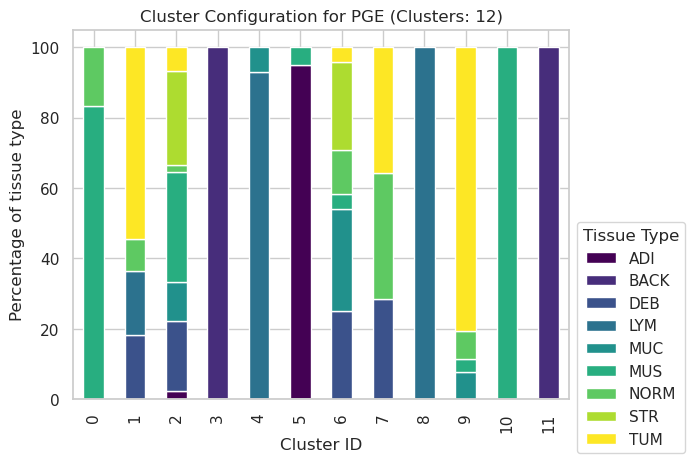

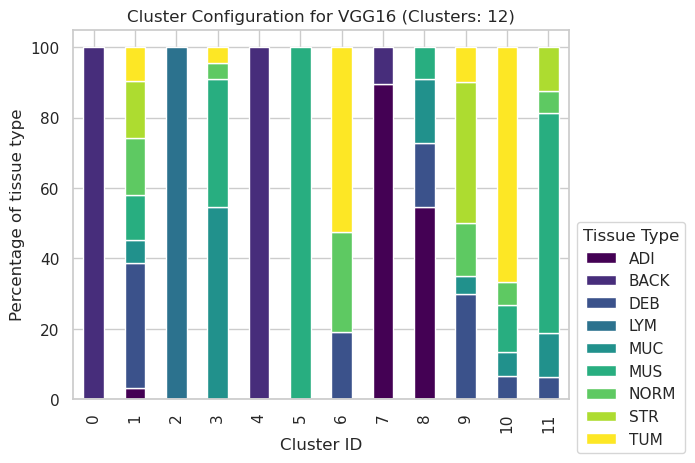

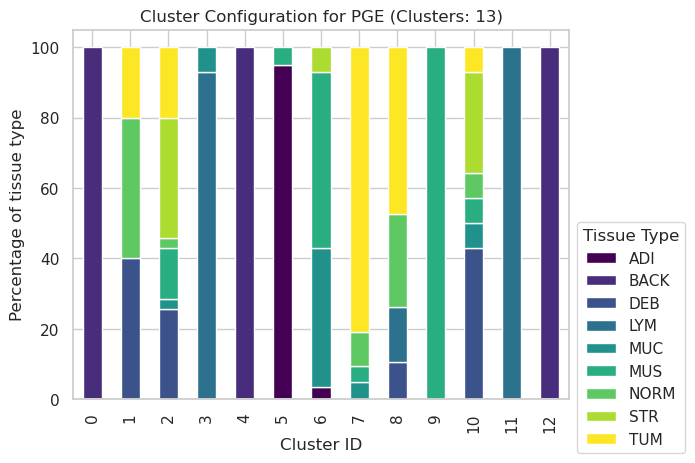

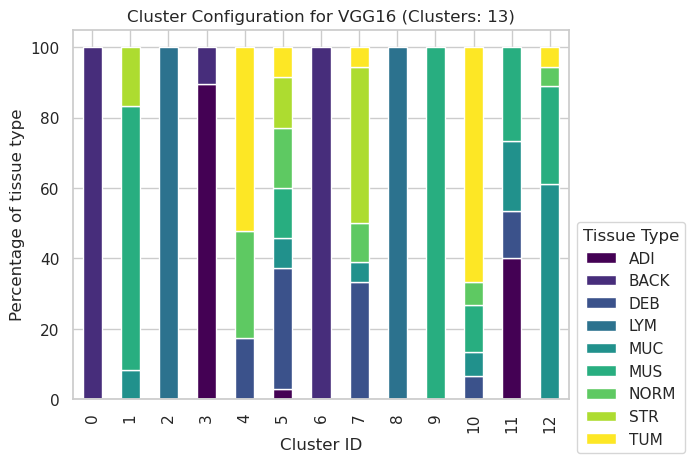

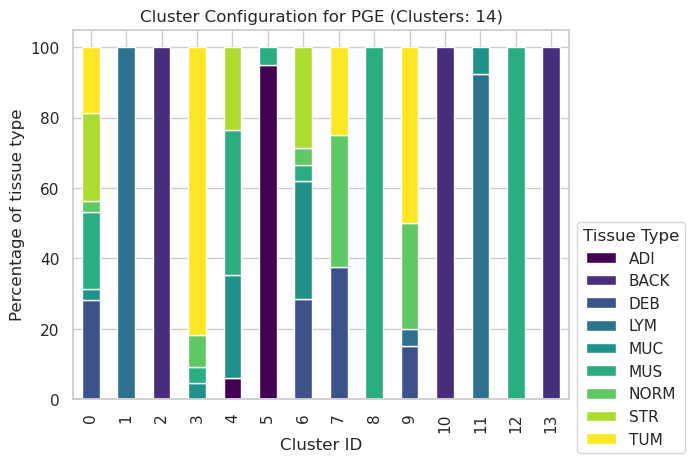

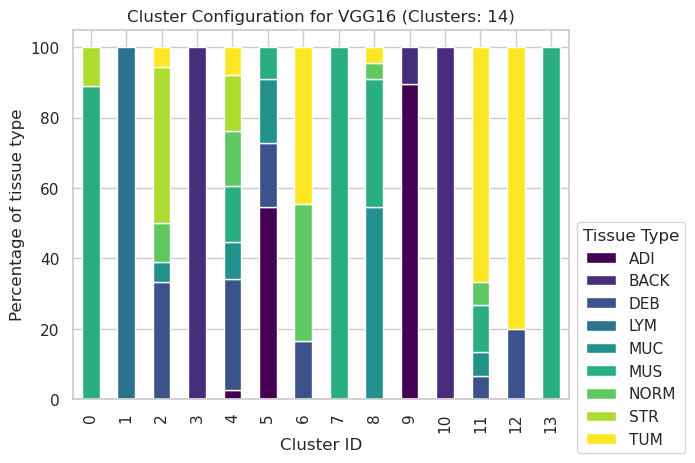

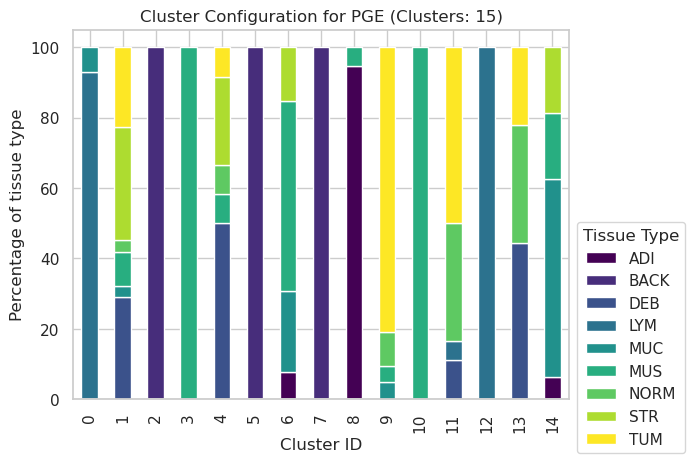

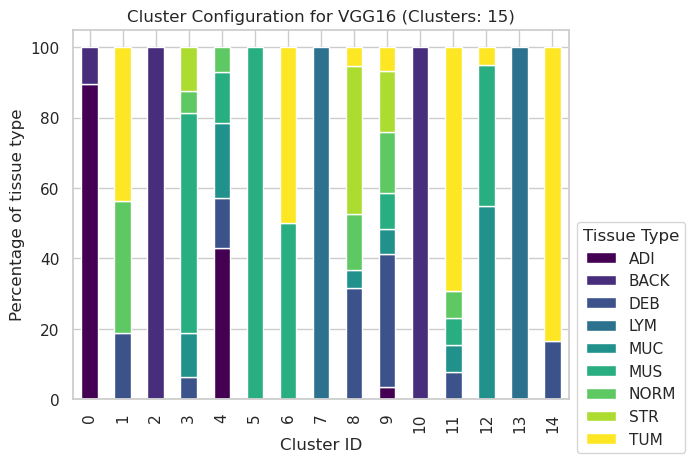

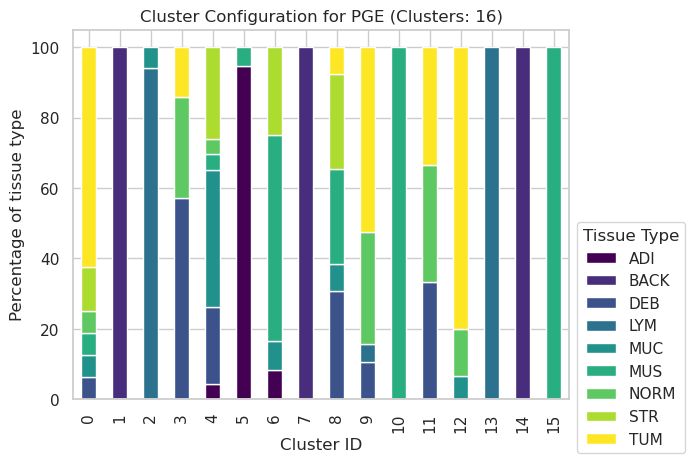

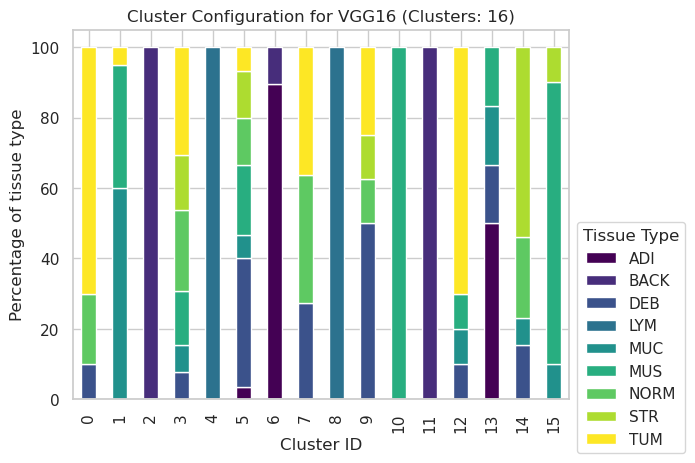

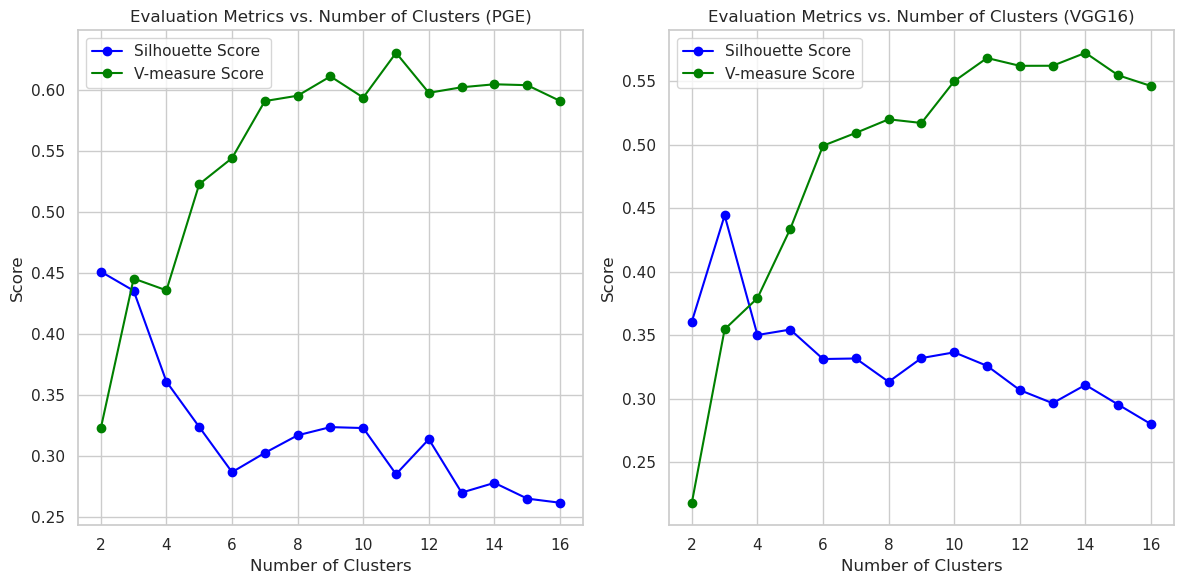


Best Cluster Size and Score for PGE (Silhouette): {'size': 2, 'score': 0.45089296}
Best Cluster Size and Score for PGE (V-measure): {'size': 11, 'score': 0.6303839325933294}

Best Cluster Size and Score for VGG16 (Silhouette): {'size': 3, 'score': 0.44442314}
Best Cluster Size and Score for VGG16 (V-measure): {'size': 14, 'score': 0.572529446717271}


In [8]:
# Set Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Loop through different numbers of clusters
for num_clusters in num_clusters_list:
    # K-means clustering for PGE
    kmeans_model_pge = KMeans(n_clusters=num_clusters, n_init=10, random_state=0)
    kmeans_assignments_pge = kmeans_model_pge.fit_predict(test_data_pge)

    # Calculate silhouette and V-measure scores for PGE
    silhouette_pge = silhouette_score(test_data_pge, kmeans_assignments_pge)
    v_measure_pge = v_measure_score(test_labels_pge, kmeans_assignments_pge)

    # Update best cluster size and score for PGE based on silhouette score
    if silhouette_pge > best_cluster_pge["silhouette"]["score"]:
        best_cluster_pge["silhouette"]["size"] = num_clusters
        best_cluster_pge["silhouette"]["score"] = silhouette_pge

    # Update best cluster size and score for PGE based on v-measure score
    if v_measure_pge > best_cluster_pge["v_measure"]["score"]:
        best_cluster_pge["v_measure"]["size"] = num_clusters
        best_cluster_pge["v_measure"]["score"] = v_measure_pge

    silhouette_scores_pge.append(silhouette_pge)
    v_measure_scores_pge.append(v_measure_pge)


    # K-means clustering for VGG16
    kmeans_model_vgg16 = KMeans(n_clusters=num_clusters, n_init=10, random_state=0)
    kmeans_assignments_vgg16 = kmeans_model_vgg16.fit_predict(test_data_vgg16)

    # Calculate silhouette and V-measure scores for VGG16
    silhouette_vgg16 = silhouette_score(test_data_vgg16, kmeans_assignments_vgg16)
    v_measure_vgg16 = v_measure_score(test_labels_vgg16, kmeans_assignments_vgg16)

    # Update best cluster size and score for VGG16 based on silhouette score
    if silhouette_vgg16 > best_cluster_vgg16["silhouette"]["score"]:
        best_cluster_vgg16["silhouette"]["size"] = num_clusters
        best_cluster_vgg16["silhouette"]["score"] = silhouette_vgg16

    # Update best cluster size and score for VGG16 based on v-measure score
    if v_measure_vgg16 > best_cluster_vgg16["v_measure"]["score"]:
        best_cluster_vgg16["v_measure"]["size"] = num_clusters
        best_cluster_vgg16["v_measure"]["score"] = v_measure_vgg16

    silhouette_scores_vgg16.append(silhouette_vgg16)
    v_measure_scores_vgg16.append(v_measure_vgg16)

    # Bar plot for each cluster configuration (PGE)
    label_proportion_pge = pd.DataFrame({'clusterID': kmeans_assignments_pge, 'type': test_labels_pge})
    label_proportion_pge = label_proportion_pge.groupby(['clusterID']).apply(lambda x: x['type'].value_counts(normalize=True)).unstack().fillna(0) * 100
    label_proportion_pge.plot(kind='bar', stacked=True, colormap='viridis')
    plt.title(f'Cluster Configuration for PGE (Clusters: {num_clusters})')
    plt.xlabel('Cluster ID')
    plt.ylabel('Percentage of tissue type')
    plt.legend(title='Tissue Type', loc='upper right', bbox_to_anchor=(1.25, 0.5))
    plt.show()

    # Bar plot for each cluster configuration (VGG16)
    label_proportion_vgg16 = pd.DataFrame({'clusterID': kmeans_assignments_vgg16, 'type': test_labels_vgg16})
    label_proportion_vgg16 = label_proportion_vgg16.groupby(['clusterID']).apply(lambda x: x['type'].value_counts(normalize=True)).unstack().fillna(0) * 100
    label_proportion_vgg16.plot(kind='bar', stacked=True, colormap='viridis')
    plt.title(f'Cluster Configuration for VGG16 (Clusters: {num_clusters})')
    plt.xlabel('Cluster ID')
    plt.ylabel('Percentage of tissue type')
    plt.legend(title='Tissue Type', loc='upper right', bbox_to_anchor=(1.25, 0.5))
    plt.show()

# Plotting results for PGE and VGG16
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(num_clusters_list, silhouette_scores_pge, marker='o', label='Silhouette Score', color='blue')
plt.plot(num_clusters_list, v_measure_scores_pge, marker='o', label='V-measure Score', color='green')
plt.title('Evaluation Metrics vs. Number of Clusters (PGE)')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(num_clusters_list, silhouette_scores_vgg16, marker='o', label='Silhouette Score', color='blue')
plt.plot(num_clusters_list, v_measure_scores_vgg16, marker='o', label='V-measure Score', color='green')
plt.title('Evaluation Metrics vs. Number of Clusters (VGG16)')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print best cluster sizes and scores
print("\nBest Cluster Size and Score for PGE (Silhouette):", best_cluster_pge["silhouette"])
print("Best Cluster Size and Score for PGE (V-measure):", best_cluster_pge["v_measure"])
print("\nBest Cluster Size and Score for VGG16 (Silhouette):", best_cluster_vgg16["silhouette"])
print("Best Cluster Size and Score for VGG16 (V-measure):", best_cluster_vgg16["v_measure"])